In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np

In [5]:
from src.models import model

In [6]:
device = "cuda"

In [7]:
PINN = model.PINN_import("./results/2025-05-22_11-59-35/model_intermediate_model.pth", input_len=256, output_len=3, RFF = True, device = device)

In [8]:
datafile = "./data/cylinder.csv"

In [9]:
df = pd.read_csv(datafile)

In [10]:
horizon = df.loc[np.abs(df["Points:0"])<0.05].reset_index()
horizon = horizon[horizon["Points:2"]==0.5]

In [11]:
time = np.random.randint(1, 149)

In [12]:
horizon = horizon[horizon["Time"]==time]

In [13]:
horizon = horizon[horizon["Points:1"]>0.]

In [36]:
horizon = horizon[horizon["Points:1"]<2.]

In [37]:
horizon.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, 6957 to 6968
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     12 non-null     int64  
 1   TimeStep  12 non-null     int64  
 2   Time      12 non-null     int64  
 3   Points:0  12 non-null     float64
 4   Points:1  12 non-null     float64
 5   Points:2  12 non-null     float64
 6   U:0       12 non-null     float64
 7   U:1       12 non-null     float64
 8   U:2       12 non-null     float64
 9   p         12 non-null     float64
dtypes: float64(7), int64(3)
memory usage: 1.0 KB


In [38]:
y_axis = horizon["Points:1"].values
u_x = horizon["U:0"].values
x_axis = horizon["Points:0"].values
abs_x_axis = np.abs(x_axis)

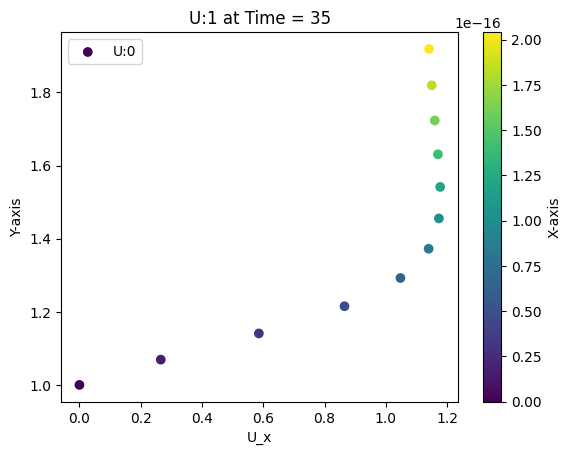

In [39]:
plt.scatter(u_x, y_axis, c = abs_x_axis, cmap='viridis', label="U:0")
plt.xlabel("U_x")
plt.ylabel("Y-axis")
plt.title("U:1 at Time = {}".format(time))
plt.legend()
plt.colorbar(label="X-axis")
plt.show()

In [1]:
Y_range = torch.linspace(-1.5, 1.5, 100)
## give me a tensor of (0., Y_range, time) knowing that Y_range is a tensor of shape (100,)
X_axis = torch.zeros((Y_range.shape[0]))
time_axis = time * torch.ones((Y_range.shape[0]))

input_tensor = torch.stack((X_axis, Y_range, time_axis), dim=1)
input_tensor = input_tensor.to(device)

NameError: name 'torch' is not defined

In [32]:
PINN = PINN.to(device)

In [33]:
U_x_pred = PINN(input_tensor)

In [34]:
y_axis = input_tensor[:, 1].cpu().detach().numpy()
u_x_axis = U_x_pred[:, 0].cpu().detach().numpy()

/tmp/ipykernel_1306008/3617828303.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


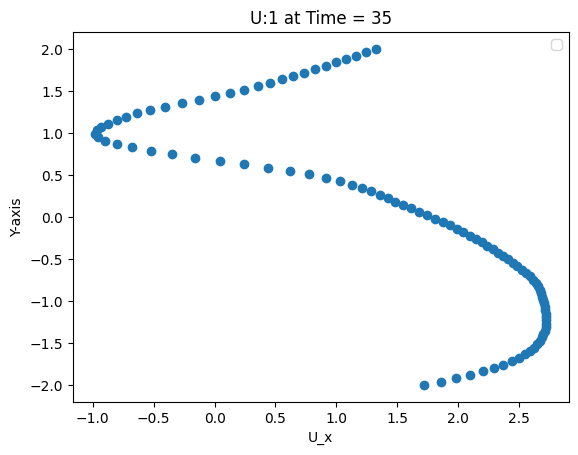

In [35]:
plt.scatter(u_x_axis, y_axis,)
plt.xlabel("U_x")
plt.ylabel("Y-axis")
plt.title("U:1 at Time = {}".format(time))
plt.legend()
plt.show()